<a href="https://colab.research.google.com/github/Madrinmarison/Deep_Learning/blob/main/Food_Vision_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🍔👁 Food Vision with Transfer Learning

This notebook leverages the power of transfer learning, feature extraction and fine tuning, to scale up a multclass model to all of the classes in Food101 (101 total classes of food).

**Goal:** Beat the original Food101 paper with only 10% of the training data (leveraging the power of transfer learning).

Originlal [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) paper:

Our baseline to beat is 50.76% across 101 classes.

In [ ]:
# make sure you are connected to the GPU
!nvidia-smi

Thu Sep  8 18:31:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

The helper function we are going to use in this notebook can be downloaded [her]()

In [ ]:
# get the helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-08 18:31:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-08 18:31:12 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data

## 101 Food Classes: Working with less data.

Download the data from the original Food101 dataset. This data was preprocessed using the [image_data_modification]() notebook.

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-09-08 18:31:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   152MB/s    in 15s     

2022-09-08 18:31:30 (103 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Setup data directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
from ast import walk
# check how many image classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_fo

In [ ]:
# Set up inputs (data loaders)
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_dir ectory(train_dir,
                                                                               image_size = IMG_SIZE,
                                                                               label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size =IMG_SIZE,
                                                                shuffle = False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes.

Here are steps we are agoing to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientB0 backbned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% on test data to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        monitor = "val_accuracy",
                                                        save_weights_only = True,
                                                        save_best_only = "True")

In [ ]:
# Create data augmentation layer and inccorporate it right in the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
  # preprocessing.Rescalling(1 /255.) # reascale images <needed for models like ResNet50

], name = "data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extrat features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False #  freeze all patterns our backbone model has learnt before

# ste up model architectiture wit trainable top layers
inputs = layers.Input(shape = IMG_SIZE + (3,), name = "Input_layer")
x = data_augmentation(inputs) # augment images (this only happens during the trainng phase)
# set training to False: put base model in inference mode so weights which need to stay frozen, stay frozen
x = base_model(x, training = False) # pass inputs to the base model after augmenting them
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
# Get summary of the model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

Only parameters in our output layer are trainable (129,381).

In [ ]:
# Compile the model
model.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

                        # Fit the model
history_all_classes_10_percent =  model.fit(train_data_all_10_percent,
                                              epochs = 5, # fit for 5 epochs to keep experiment quick
                                              #steps_per_epoch = len(train_data_all_10_percent)
                                              validation_data = test_data,
                                              validation_steps =int(0.15*len(test_data)),
                                              callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 94s 323ms/step - loss: 3.4684 - accuracy: 0.2502 - val_loss: 2.7228 - val_accuracy: 0.3853
Epoch 2/5
237/237 [==============================] - 59s 247ms/step - loss: 2.3480 - accuracy: 0.4595 - val_loss: 2.2259 - val_accuracy: 0.4595
Epoch 3/5
237/237 [==============================] - 54s 224ms/step - loss: 1.9718 - accuracy: 0.5341 - val_loss: 2.0299 - val_accuracy: 0.4918
Epoch 4/5
237/237 [==============================] - 51s 214ms/step - loss: 1.7562 - accuracy: 0.5714 - val_loss: 1.9655 - val_accuracy: 0.4913
Epoch 5/5
237/237 [==============================] - 46s 193ms/step - loss: 1.6176 - accuracy: 0.5971 - val_loss: 1.9194 - val_accuracy: 0.5032


In [ ]:
# Evaluate on the whole test dataset
feature_extrction_results = model.evaluate(test_data)
feature_extrction_results

790/790 [==============================] - 58s 74ms/step - loss: 1.7172 - accuracy: 0.5499


[1.7172338962554932, 0.5499405860900879]

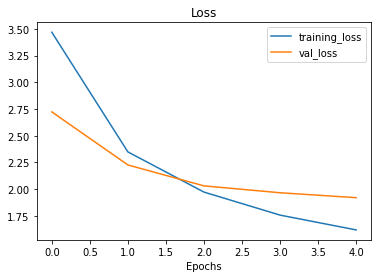

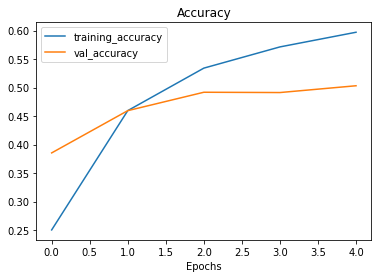

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally the two curves should be very similar to each other, if not... as in the above case, it may sugest that our model is overfitting (performing too well on the training data and not generalizing on unseen data).

It's good idea for model to overfit on the feature extraction phase and then deal with this during fine-tuning. In my experience have found this working very well and outputting a very good performing model.

## Fine tunning

In [ ]:
# Unfreeze all layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (best practice to lower learningrate when fine tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# How many layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable for our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after, (5 + 5 = 10)

# Fine tune our model
history_all_classes_10_percent_fine_tune =  model.fit(train_data_all_10_percent,
                                                      epochs = fine_tune_epochs,
                                                      validation_data = test_data,
                                                      validation_steps = int(0.15*len(test_data)),
                                                      #callbacks = [checkpoint_path],
                                                      initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 55s 201ms/step - loss: 1.3556 - accuracy: 0.6504 - val_loss: 1.8668 - val_accuracy: 0.5151
Epoch 6/10
237/237 [==============================] - 43s 182ms/step - loss: 1.2527 - accuracy: 0.6647 - val_loss: 1.8725 - val_accuracy: 0.5159
Epoch 7/10
237/237 [==============================] - 41s 174ms/step - loss: 1.1458 - accuracy: 0.7022 - val_loss: 1.8293 - val_accuracy: 0.5257
Epoch 8/10
237/237 [==============================] - 39s 163ms/step - loss: 1.0814 - accuracy: 0.7135 - val_loss: 1.8353 - val_accuracy: 0.5241
Epoch 9/10
237/237 [==============================] - 39s 164ms/step - loss: 1.0294 - accuracy: 0.7291 - val_loss: 1.8245 - val_accuracy: 0.5270
Epoch 10/10
237/237 [==============================] - 38s 159ms/step - loss: 0.9673 - accuracy: 0.7438 - val_loss: 1.8394 - val_accuracy: 0.5249


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 57s 72ms/step - loss: 1.6197 - accuracy: 0.5745


[1.6196990013122559, 0.5745346546173096]

In [ ]:
feature_extrction_results

[1.7172338962554932, 0.5499405860900879]

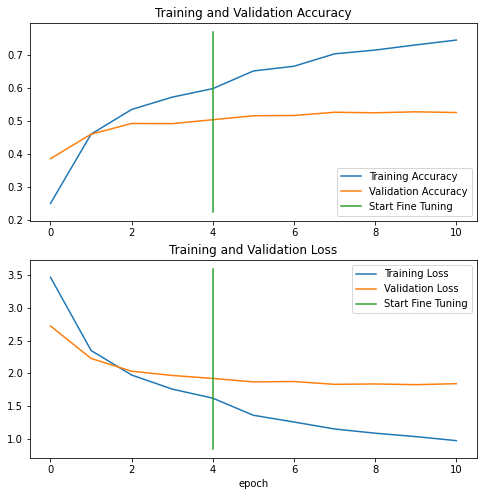

In [ ]:
# Compaire the histories of feature extraction model with fine-tuning model
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Sving and loading our model

To use our model in an external application, we need to save it and export it somewhere

In [ ]:
# Save our fine-tuned model
model.save("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Tensorflow/101_food_classes_10_percent_saved_big_dog_model")

🔑 **Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking issues on Github, however, it seems according to the TensorFlow documentation, loading warnings can be be ignored:

In [ ]:
# Evaluate our loaded model and compaire performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.6197 - accuracy: 0.5745


[1.6196990013122559, 0.5745346546173096]

In [ ]:
# The results of the loaded model above should be very similar to the results of the model below.
all_classes_10_percent_fine_tune_results

[1.6196990013122559, 0.5745346546173096]

## Evaluating the performance of the big dog model across all different classes

Let's make predictions, visualize them and then later find which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf

# Download a pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-09-08 18:47:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  39.4MB/s    in 1.1s    

2022-09-08 18:47:57 (39.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one we just loaded on the test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 60s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

Create data use GAN---> Build a model: Test with real data. Unique:

Labels ==> Name---> Should get them right....

In [ ]:
# Make predictions with our saved model
preds_probs = model.predict(test_data, verbose = 1) # set verbosity to see how long is left

790/790 [==============================] - 62s 76ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541997e-02, 3.5742044e-06, 4.1377008e-02, ..., 1.4138679e-09,
        8.3530824e-05, 3.0897509e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780820e-04, ..., 5.4287048e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925868e-01, 3.2533648e-05, 1.4866963e-03, ..., 7.1891270e-07,
        5.4397265e-07, 4.0275925e-05],
       ...,
       [4.7313246e-01, 1.2931228e-07, 1.4805609e-03, ..., 5.9750048e-04,
        6.6969005e-05, 2.3469245e-05],
       [4.4571832e-02, 4.7265476e-07, 1.2258517e-01, ..., 6.3498501e-06,
        7.5318512e-06, 3.6778776e-03],
       [7.2438955e-01, 1.9249771e-09, 5.2310937e-05, ..., 1.2291373e-03,
        1.5792714e-09, 9.6395648e-05]], dtype=float32)

In [ ]:
# what does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541997e-02, 3.5742044e-06, 4.1377008e-02, 1.0660534e-09,
        8.1614111e-09, 8.6639478e-09, 8.0927191e-07, 8.5652403e-07,
        1.9859070e-05, 8.0977674e-07, 3.1727800e-09, 9.8673911e-07,
        2.8532185e-04, 7.8049184e-10, 7.4230076e-04, 3.8916409e-05,
        6.4740357e-06, 2.4977301e-06, 3.7891128e-05, 2.0678326e-07,
        1.5538435e-05, 8.1507017e-07, 2.6230514e-06, 2.0010684e-07,
        8.3827518e-07, 5.4216030e-06, 3.7390816e-06, 1.3150530e-08,
        2.7761480e-03, 2.8051860e-05, 6.8562017e-10, 2.5574853e-05,
        1.6688880e-04, 7.6406842e-10, 4.0452872e-04, 1.3150632e-08,
        1.7957391e-06, 1.4448174e-06, 2.3062943e-02, 8.2466846e-07,
        8.5365838e-07, 1.7138658e-06, 7.0525025e-06, 1.8402130e-08,
        2.8553373e-07, 7.9483443e-06, 2.0681568e-06, 1.8525114e-07,
        3.3619767e-08, 3.1522580e-04, 1.0410922e-05, 8.5448272e-07,
        8.4741855e-01, 1.0555444e-05, 4.4094620e-07, 3.7404177e-05,
        3.5306122e-05, 3.2489035e-05, 6.7314730e

Our model outputs prediction probabilty array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs)}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the higest predicted probability by the model for sample 0: {preds_probs[0].argmax()} ")

Number of prediction probabilities for sample 0: 25250
What prediction probability sample 0 looks like:
 [5.9541997e-02 3.5742044e-06 4.1377008e-02 1.0660534e-09 8.1614111e-09
 8.6639478e-09 8.0927191e-07 8.5652403e-07 1.9859070e-05 8.0977674e-07
 3.1727800e-09 9.8673911e-07 2.8532185e-04 7.8049184e-10 7.4230076e-04
 3.8916409e-05 6.4740357e-06 2.4977301e-06 3.7891128e-05 2.0678326e-07
 1.5538435e-05 8.1507017e-07 2.6230514e-06 2.0010684e-07 8.3827518e-07
 5.4216030e-06 3.7390816e-06 1.3150530e-08 2.7761480e-03 2.8051860e-05
 6.8562017e-10 2.5574853e-05 1.6688880e-04 7.6406842e-10 4.0452872e-04
 1.3150632e-08 1.7957391e-06 1.4448174e-06 2.3062943e-02 8.2466846e-07
 8.5365838e-07 1.7138658e-06 7.0525025e-06 1.8402130e-08 2.8553373e-07
 7.9483443e-06 2.0681568e-06 1.8525114e-07 3.3619767e-08 3.1522580e-04
 1.0410922e-05 8.5448272e-07 8.4741855e-01 1.0555444e-05 4.4094620e-07
 3.7404177e-05 3.5306122e-05 3.2489035e-05 6.7314730e-05 1.2852565e-08
 2.6219704e-10 1.0318108e-05 8.5744112e-05 

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis = 1)

# How do they look
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got the prediction array of all of our model's predictions, to evaluate them, we need to compaire them to the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch(): # currently test labels are one-hot encoded: [0,0,0,..,1,0,0], we want the index where the "1" occurs.
  y_labels.append(labels.numpy().argmax())

y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y labels are there
len(y_labels)

25250

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Evaluating our model's predictions
Ome way to check that our model's predictions array is in the same order as our test labels array labels array is to find the accuracy score

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

In [ ]:
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [ ]:
# Get a lis of class names
class_names = test_data.class_names

In [ ]:
## Let's get visual: making a confusion metrix
from helper_functions import make_confusion_matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# make chages
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Change: Plot the x-lables vertically###
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

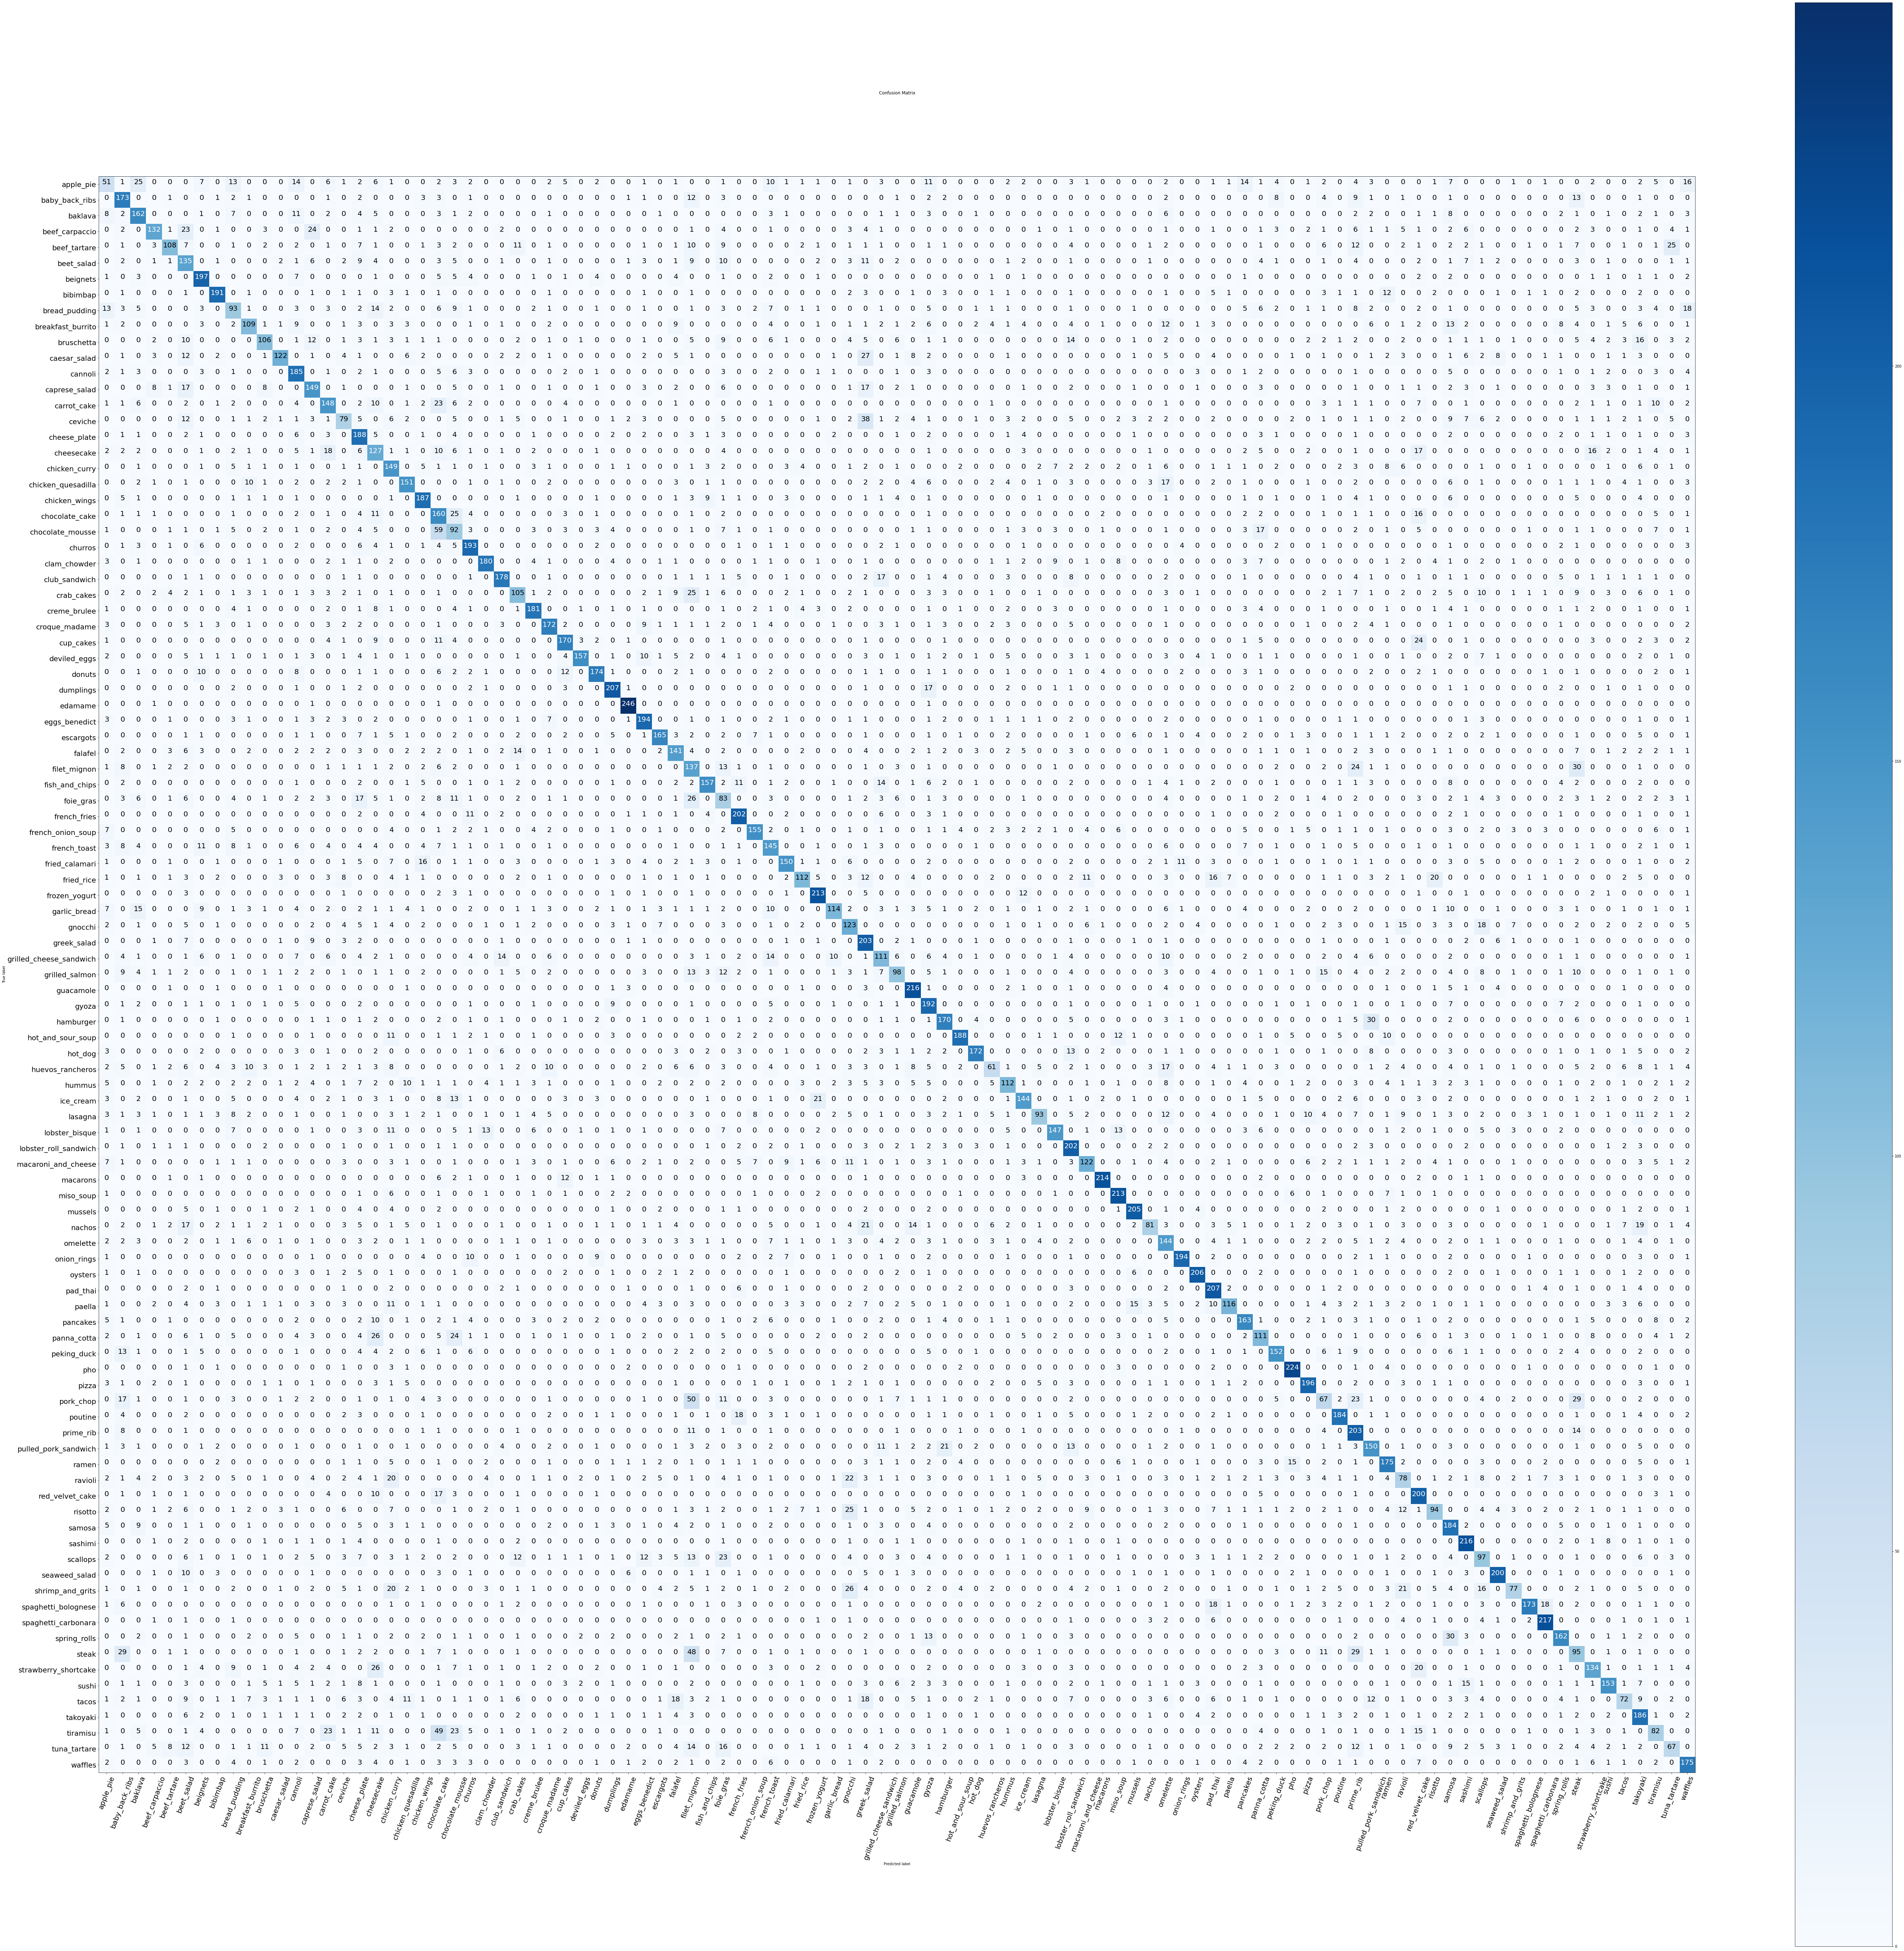

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20,
                      savefig = True)

## Let's keep the evaluation train going, time for classification report.

Scikit-learn has a helpful function for acquiring many different classification metrics oer class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evalustion of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding.

In [ ]:
# Get a dictionary of classification report
classfication_report_dict = classification_report(y_labels,
                                                  pred_classes,
                                                  output_dict = True)
classfication_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores...

In [ ]:
# Create an empty dictionary
class_f1_scores = {}
# Loop through classification_report items
for k, v in classfication_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy
         break
    else:
        # Add class names and f1-scaires to the new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
list(class_f1_scores.keys())

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Turn f1-scores into a dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1-scores": list(class_f1_scores.values())}).sort_values("f1-scores", ascending = False)                    

In [ ]:
f1_scores

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
..                  ...        ...
56     huevos_rancheros   0.339833
22     chocolate_mousse   0.329159
77            pork_chop   0.308756
39            foie_gras   0.297491
0             apple_pie   0.240566

[101 rows x 2 columns]

In [ ]:
f1_scores[:10]

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
68          onion_rings   0.832618
65              mussels   0.820000
88        seaweed_salad   0.813008
64            miso_soup   0.812977
45        frozen_yogurt   0.811429

In [ ]:
f1_scores[-10:]

class_names  f1-scores
96             tacos   0.380952
15           ceviche   0.367442
99      tuna_tartare   0.353562
82           ravioli   0.342857
93             steak   0.342342
56  huevos_rancheros   0.339833
22  chocolate_mousse   0.329159
77         pork_chop   0.308756
39         foie_gras   0.297491
0          apple_pie   0.240566

In [ ]:
def autolabel(scores):
    for score in scores:
      height = score.get_height()
      ax.text(score.get_x() + score.get_width()/2, 1.05*height,
              "%d" % int(height),
              ha = "center", va = "bottom")

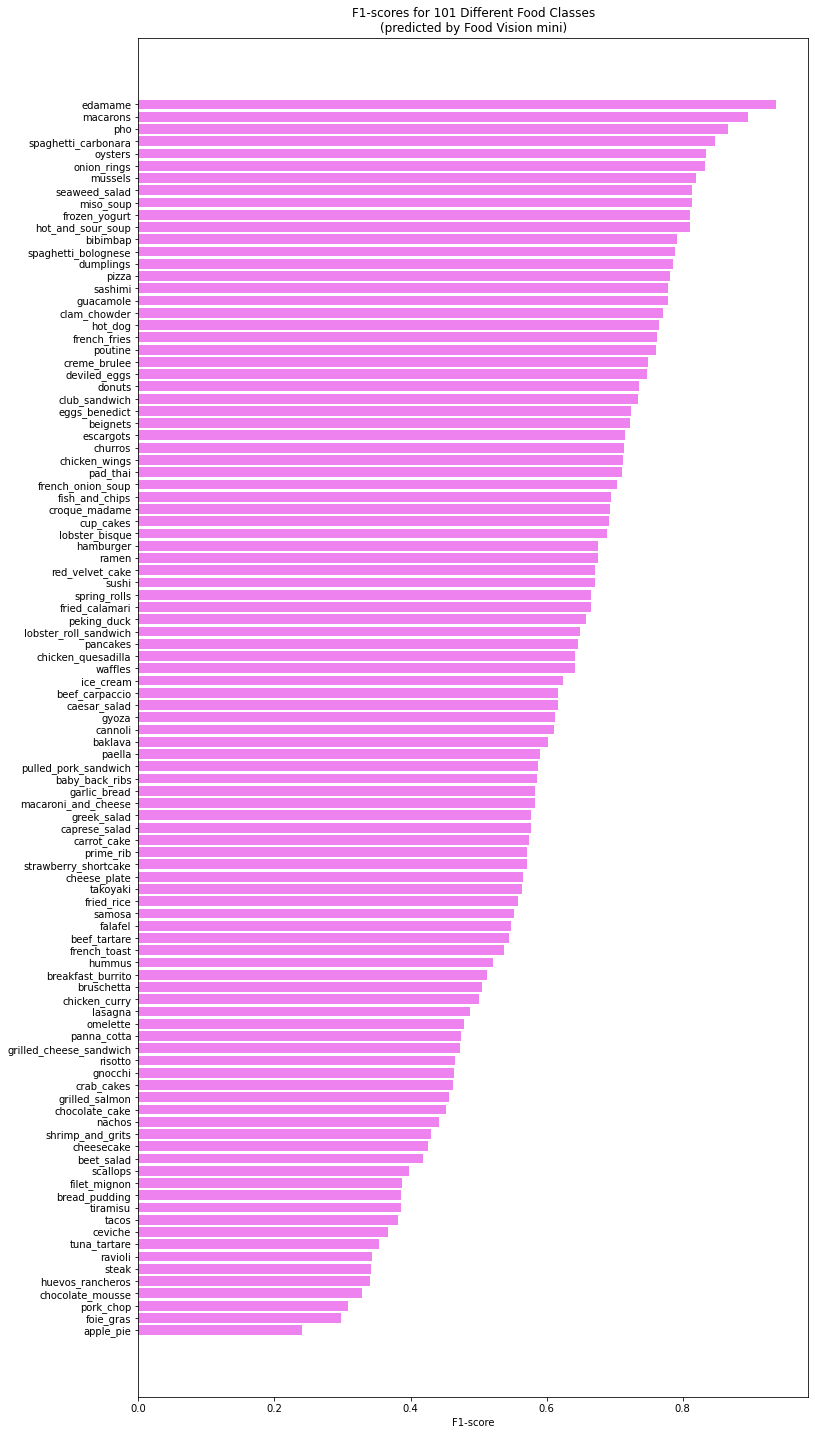

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values, color = "violet") # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes\n(predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse order of our plot

🛠 **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. apple_pie, pork_chip), do you notice any trends among them? Why might our model be having trouble with them.

## Visualizing predictions on test images
Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images we'll need a function to load and preprocess images, specifically will need to:
* Read in a target image filepath using `tf.io.read_file()`.
Turn the image into a tensor using `tf.io.read_file()`.
* Resize the image tensor to be the same as the images our model has trained on using `tf.image.resize()`.
* Scale the image to get all of the pixel values between 0 & 1 (if neccessary)


In [ ]:
# Create a function to load and prepare images
def load_and_prepare_image(filename, img_shape = 224, scale = True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes 
    into the specified shape (img_shape, img_shape, color_chanels = 3).

    Args:
        filename (str): path to target image.
        img_shape (int): height/width dimension of target image size.
        scale (bool): scale pixel values from 0-255 to 0-1 or not.

    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    # Read in the target image
    img = tf.io.read_file(filename)

    # Decode image into a tensor
    img = tf.io.decode_image(img, channels = 3)

    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])

    # scale? Yes/no
    if scale:
        # rescale the image (get all values between 0 & 1)
        return img/255.
    else:
      return img # don't need to rescale images for EfficientNet models in Tensorflow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset.
2. Make predictions on the loaded image.
3. PLot the models original image(s) along with the model's predictions, prediction probability and truth label.

101_food_classes_10_percent/test/filet_mignon/2286742.jpg
101_food_classes_10_percent/test/cannoli/2217076.jpg
101_food_classes_10_percent/test/pad_thai/517387.jpg


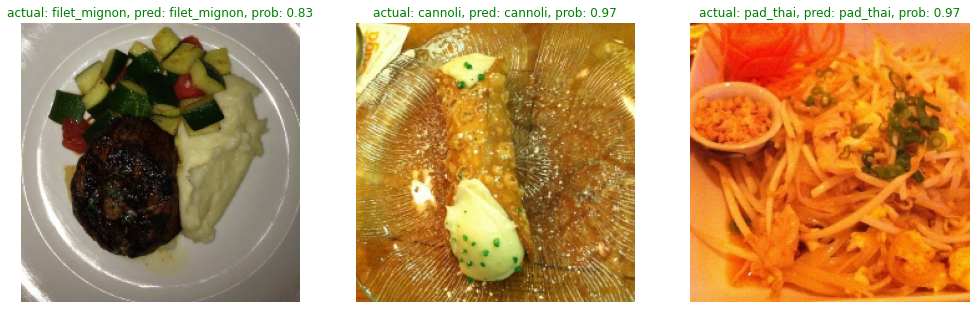

In [ ]:

# Make preds on a series of random images
import os
import random
plt.figure(figsize = (17, 10))
for i in range (3):
  # Chose a random image from a rondom class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make prediction
  img = load_and_prepare_image(filepath, scale = False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis = 0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it to class_names list
  #print(pred_prob)
  #print(pred_class)

  # Plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.0)

  if class_name == pred_class: # if predicted class matches truth class, make tesxt green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False);

## Find the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the folowing:
1. Get all of the image file paths in the test dataset using list_file() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't macth the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability at the top).
5. Visualize the images with the highest prediction probabilities but have wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
    filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf":preds_probs.max(axis = 1),
                        "y_true_classnames":[class_names[i] for i in y_labels],
                        "y_pred_classnames": [class_names[i] for i in pred_classes]})

pred_df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_conf y_true_classnames     y_pred_classnames  
0       0.847419         apple_pie                 gyoza  
1       0.964017         apple_pie             apple_pie  
2       0.959259         apple_pie             apple_pie  
3       0.658607         apple_pie  pulled_pork_sandwich  
4       0.367901         apple_pie             prime_rib  
...          ...               ...                   ...  
25245   0.972823           waffles               waffles  
25246   0.878028           waffles          cheese_plate  
25247   0.537899           waffles               waffles  
25248   0.501950           waffles  strawberry_shortcake  
25249   0.690628           waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_conf y_true_classnames     y_pred_classnames  pred_correct  
0   0.847419         apple_pie                 gyoza         False  
1   0.964017         apple_pie             apple_pie          True  
2   0.959259         apple_pie             apple_pie          True  
3   0.658607         apple_pie  pulled_pork_sandwich         False  
4   0.367901         apple_pie             prime_rib         False

In [ ]:
# Sort our DataFrame to have the most wrong predictions at the topp
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)[:100]

In [ ]:
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
24540  b'101_food_classes_10_percent/test/tiramisu/16...      98      83   
2511   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
5574   b'101_food_classes_10_percent/test/chocolate_m...      22      21   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
1155   b'101_food_classes_10_percent/test/beef_tartar...       4       5   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23904  b'101_food_classes_10_percent/test/sushi/33652...      95      86   
7316   b'101_food_classes_10_percent/test/cup_cakes/1...      29      83   
13144  b'101_food_classes_10_percent/test/gyoza/31214...      52      92   
10880  b'101_food_classes_10_percent/test/fried_calam...      43      68   

       pred_conf      y_true_classnames      y_pred_classnames  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

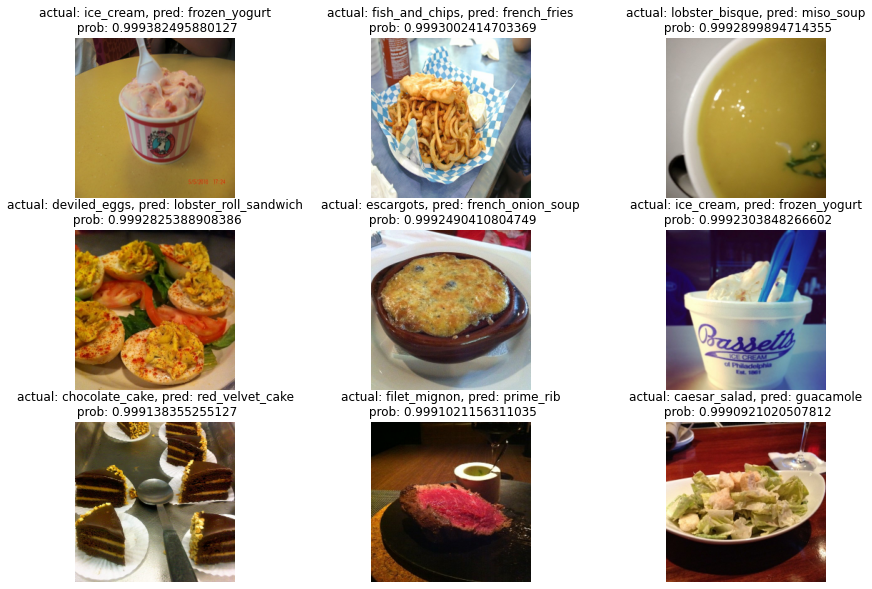

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probabily.
images_to_view = 9
start_index = 30
plt.figure(figsize = (15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img = load_and_prepare_image(row[1], scale = False)
    _,_,_,_,pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}\n prob: {pred_prob:.2}")
    plt.axis(False);

## Test out the big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-09-08 20:04:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  24.0MB/s    in 0.5s    

2022-09-08 20:04:07 (24.0 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get the custom food inages file paths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

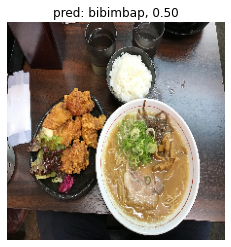

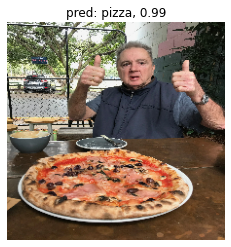

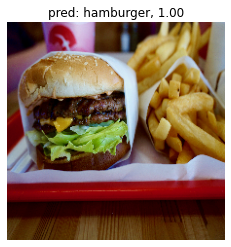

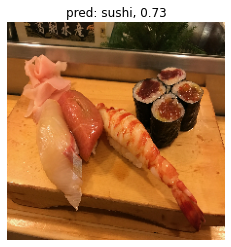

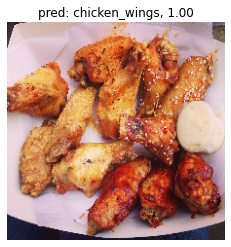

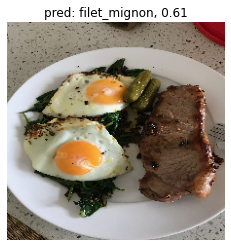

In [ ]:
# Make and plot custom food images predictions
for img in custom_food_images:
    img = load_and_prepare_image(img,scale = False) # Using EfficientNet model
    pred_prob = model.predict(tf.expand_dims(img, axis = 0)) # make prediction on image with shape [1,224,224,3] (same shape as the model was trained on)
    pred_class = class_names[pred_prob.argmax()] # get index with the highest prediction probability
    # Plot the appropriate information
    plt.figure()
    plt.imshow(img/255.0)
    plt.title(f"pred: {pred_class}, {pred_prob.max():.2f}")
    plt.axis(False)